In [2]:
import numpy as np
from scipy.special import j0, j1
import matplotlib.pyplot as plt

In [3]:
loadRadius = 0.1 #Radius [m]
pressure = 0.67 #Stress [MPa]
s = 3*loadRadius #Separation betweeen centers [m]
zi = [0.3, 1] # [m] Distance until interface
module = [3000, 500, 50] # [MPa] 
poisson = [0.45, 0.35, 0.4] 
thickness = [0.3, 0.7] # [m]

# m = np.array([1e-10, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60,
#               1.80, 2.00, 2.20, 2.40, 2.60, 2.80, 3.00, 3.20, 3.40, 3.60, 3.80,
#               4.00, 4.20, 4.40, 4.60, 4.80, 5.00, 5.50, 6.00, 6.50, 7.00, 7.50,
#               8.00, 8.50, 9.00, 9.50, 10.00, 11.00, 12.00, 13.00, 14.00, 15.00,
#               16.00, 17.00, 18.00, 19.00, 20.00, 25.00, 30.00, 35.00, 40.00,
#               45.00, 50.00, 55.00, 60.00, 65.00, 70.00, 75.00, 80.00, 85.00,
#               90.00, 95.00, 100.00, 110.00, 120.00, 130.00, 140.00, 150.00,
#               160.00, 170.00, 180.00, 190.00, 200.00, 210.00, 220.00, 230.00,
#               240.00, 250.00, 260.00, 270.00, 280.00, 290.00, 300.00, 350.00,
#               400.00, 450.00, 500.00, 600.00, 700.00, 800.00, 900.00, 1000.00,
#               2000.00, 10000.00, 100000.00])

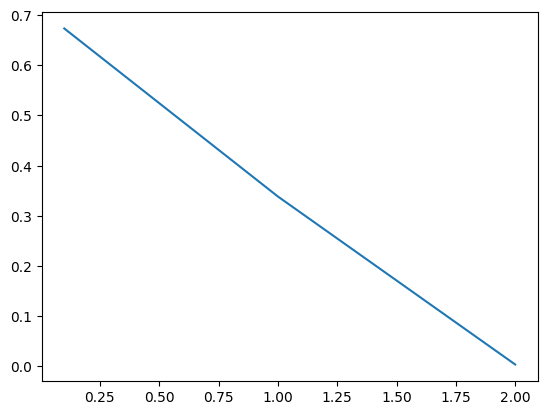

In [4]:
totalThickness = sum(thickness)
alpha = loadRadius / totalThickness
n_k = 10000
delta_m = 5
limit = n_k * delta_m
# The values of m are created with np.linspace and with 
# np.insert is added 0 to the beginning of the array m 
m = np.insert(np.linspace(delta_m, limit, n_k) - delta_m / 2, 0, 0.0001)
layerToAnalyze = np.array([0, 1])
distanceRadial = np.array([0.01, 0.1, 0.2])
distanceVertical = np.array([0.299, 0.999])
pressureHankel = np.zeros((len(distanceRadial), 1))

for i in range(len(distanceRadial)):
    besselFuntions = j0(m*distanceRadial[i]) * j1(m * alpha) * delta_m
    pressureHankel[i] = pressure * alpha * sum(besselFuntions)

fig, ax = plt.subplots()
ax.plot(distanceRadial/loadRadius, pressureHankel)
plt.show()

In [5]:
lambda_i = np.array(zi) / totalThickness # lambda = zi/H
subtractLambdas = np.concatenate(([lambda_i[0]], np.diff(lambda_i))) # e^(-m(lambda_i - lambda_i-1))
# R = E_i/E_i+1 * (poissonPlusOne_i+1/poissonPlusOne_i)
poissonPlusOne = np.array(poisson) + 1
modulesRelation = np.divide(module[0:-1], module[1:])
poissonRelation = np.divide(poissonPlusOne[1:], poissonPlusOne[0:-1])
R = poissonRelation * modulesRelation #Known as R in the books

deltaVerticalStress = 0
deltaRadialStress = 0

In [6]:
verticalStress = np.zeros((len(distanceVertical), 1))

for jj in range(len(distanceVertical)):
    
        for ii in range(len(m)):
        
            F = np.append(np.exp(-m[ii]*subtractLambdas),0)
            # Matriz primera capa z=0 sigma_z=-mJ0(m*distanceRadial) y tau_rz=0
            x_1 = np.array([[np.exp(-m[ii]*lambda_i[0]), 1, np.exp(-m[ii]*lambda_i[0])*(2*poisson[0]-1), 1-2*poisson[0]],
                        [np.exp(-m[ii]*lambda_i[0]), -1, np.exp(-m[ii]*lambda_i[0])*(2*poisson[0]), 2*poisson[0]]])

            # Lista de coeficientes desde la segunda capa hasta la ultima capa
            nLayers = np.array(module).size
            rangeStop = nLayers - 1
            unknownCoefficients = nLayers * 4 - 2
            M = [np.zeros((4,4)) for i in range(rangeStop)]
            N = [np.zeros((4,4)) for i in range(rangeStop)]

            for i in range(rangeStop):
                
                M[i] = np.array([   [1,     F[i],   - 1 + 2 * poisson[i] + m[ii] * lambda_i[i],  (1 - 2 * poisson[i] + m[ii] * lambda_i[i]) * F[i]], 
                                    [1,     -F[i],  2 * poisson[i] + m[ii] * lambda_i[i],        (2 * poisson[i] - m[ii] * lambda_i[i]) * F[i]], 
                                    [1,     F[i],   1 + m[ii] * lambda_i[i],                     (-1 + m[ii] * lambda_i[i]) * F[i]], 
                                    [1,     -F[i],  - 2 + 4 * poisson[i] + m[ii] * lambda_i[i],  (- 2 + 4 * poisson[i] - m[ii] * lambda_i[i]) * F[i]]])
                
                if i < rangeStop:
                    N[i] = np.array([   [F[i+1],            1,      (- 1 + 2 * poisson[i+1] + m[ii] * lambda_i[i]) * F[i+1],         1 - 2 * poisson[i+1] + m[ii] * lambda_i[i]],
                                        [F[i+1],            -1,     (2 * poisson[i+1] + m[ii] * lambda_i[i]) * F[i+1],               2 * poisson[i+1] - m[ii] * lambda_i[i]],
                                        [R[i] * F[i+1],     R[i],   (1 + m[ii] * lambda_i[i]) * R[i] * F[i+1],                       (-1 + m[ii] * lambda_i[i]) * R[i]],
                                        [R[i] * F[i+1],     -R[i],  (- 2 + 4 * poisson[i+1] + m[ii] * lambda_i[i]) * R[i] * F[i+1],  (- 2 + 4 * poisson[i+1] - m[ii] * lambda_i[i]) * R[i]]])

            globalArray = np.array(np.zeros((unknownCoefficients, unknownCoefficients + 2)))
            globalArray[0:2, 0:4] = x_1

            for i, array in enumerate(M):
                position = i * 4 + 2
                globalArray[position:position + 4,position-2:position + 2] = M[i]
                globalArray[position:position + 4, position+2:position + 6] = N[i]

            globalArray = np.delete(globalArray, [-2, -4], axis=1)
            resultsVector = np.array(np.zeros((unknownCoefficients, 1)))
            resultsVector[0] = 1
            coefficients = np.linalg.solve(globalArray, resultsVector)
            
            # Save globalArray in a .csv file
            # np.savetxt('globalArray.csv',globalArray, delimiter=",")
            
            deltaVerticalStress += -j0(m[ii]*0.01) * j1(m[ii]*alpha) * delta_m * alpha * pressure * (
                (coefficients[0] - coefficients[2] * (1 - 2 * poisson[0] - m[ii] * distanceVertical/totalThickness)) * np.exp(-m[ii] * (lambda_i[0] - distanceVertical/totalThickness)) + 
                (coefficients[1] + coefficients[4] * (1 - 2 * poisson[0] + m[ii] * distanceVertical/totalThickness)) * np.exp(-m[ii] * (distanceVertical/totalThickness - lambda_i[0])))            
    
        verticalStress = deltaVerticalStress 
            

C:\Users\sergi\AppData\Local\Temp\ipykernel_8976\4180361161.py:49: RuntimeWarning: overflow encountered in exp
  (coefficients[0] - coefficients[2] * (1 - 2 * poisson[0] - m[ii] * distanceVertical/totalThickness)) * np.exp(-m[ii] * (lambda_i[0] - distanceVertical/totalThickness)) +
C:\Users\sergi\AppData\Local\Temp\ipykernel_8976\4180361161.py:48: RuntimeWarning: invalid value encountered in add
  deltaVerticalStress += -j0(m[ii]*0.01) * j1(m[ii]*alpha) * delta_m * alpha * pressure * (
C:\Users\sergi\AppData\Local\Temp\ipykernel_8976\4180361161.py:49: RuntimeWarning: invalid value encountered in multiply
  (coefficients[0] - coefficients[2] * (1 - 2 * poisson[0] - m[ii] * distanceVertical/totalThickness)) * np.exp(-m[ii] * (lambda_i[0] - distanceVertical/totalThickness)) +


In [7]:
verticalStress

array([1.36642115e+18,            nan])